In [1]:
import numpy as np
import lightkurve as lk
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

/Users/azib/micromamba/envs/exocomet/lib/python3.8/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/azib/.lightkurve/cache. Please move all the files in the legacy directory /Users/azib/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:
def gauss(x, A, mu, sigma):
    return abs(A)*np.exp( -(x - mu)**2 / (2 * sigma**2) )

def comet_ingress(x, A, mu, sigma, shape):
    '''exponential comet ingress, `shape` controls curviness'''
    sh = shape/sigma
    norm = 1 - np.exp(-sh*sigma)
    return A/norm*(1 - np.exp(-sh*(x-mu+sigma)))

def comet_curve2(x, A, mu, sigma, tail, shape=3):
    return np.piecewise(x, [x<(mu-sigma), np.logical_and(x>=(mu-sigma), x<mu), x>=mu],
                        [0,
                         lambda t: comet_ingress(t, A, mu, sigma, shape),
                         lambda t: A*np.exp(-abs(t-mu)/tail)])

## Beta Pic

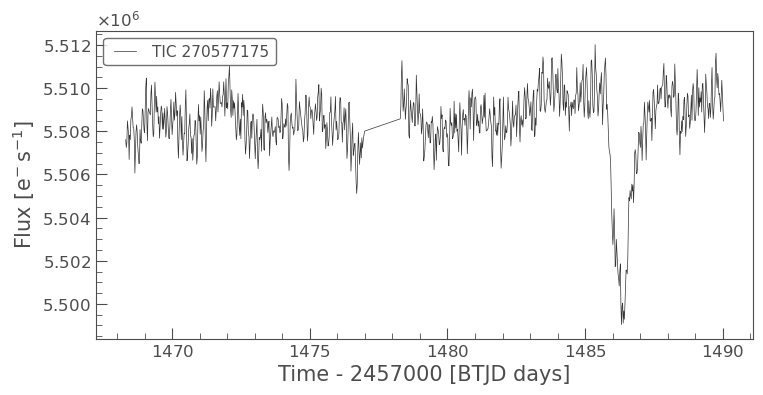

In [3]:
lc = lk.search_lightcurve('Beta Pic',sector=6,author='TESS-SPOC')[0].download()
lc = lc[lc.quality.value == 0]
lc = lc.remove_nans()
lc.plot();
plt.show()

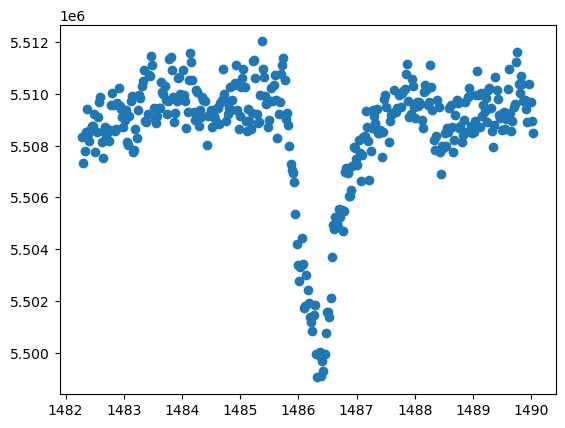

In [4]:
plt.scatter(lc.time.value[600:1000],lc.flux.value[600:1000])
plt.show()

In [5]:
def comet_curve_fit(x,y):
    # Initial parameters guess
    # x = time
    # y = flux
    i = np.argmax(y)

    width = x[-1]-x[0]

    params_init = [y[i],x[i],width/3,width/3,width/3]

    # def comet_curve2(x, A, mu, sigma, tail, shape=3):

    params_bounds = [[0,x[0],0,0,0.1], [np.inf,x[-1],width/2,width/2,5]]
    params,cov = curve_fit(comet_curve2,x,y,params_init,bounds=params_bounds)
    return params, cov

In [6]:
flux = lc.flux.value[600:1000]/np.nanmedian(lc.flux.value)

In [7]:
params, cov = comet_curve_fit(lc.time.value[600:1000],flux)

In [8]:
fit = -comet_curve2(lc.time.value[600:1000],*params)

In [9]:
params

array([1.26329468e+00, 1.48583029e+03, 3.87496118e+00, 3.87496118e+00,
       5.00000000e+00])

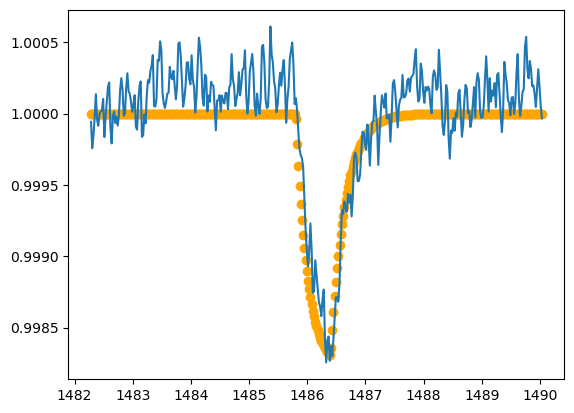

In [40]:
plt.plot(lc.time.value[600:1000],flux,c='#1f77b4')
plt.scatter(lc.time.value[600:1000],1-comet_curve2(lc.time.value[600:1000],0.0017,1486.4,0.6,0.25,3),c='orange')
plt.show()

---

## Zieba model

In [73]:
def modelexi(tin, y, yerr, tmid, bimpact, cmax, lam, P, Mstar, Rstar, ulimb, extra=False):

    tinmin = tin.min()
    tinmax = tin.max()
    tdelt = tinmax - tinmin
    
    # make a wider range of regularly spaced times so that convolution doesn't have round off error
    t_model = np.linspace(tinmin-tdelt, tinmax+tdelt, 10001)
    
    # convert time to orbital phase angle
    t_phase = (2*np.pi* (t_model - tmid) / P) * u.radian

    # convert period to semimajor axis
    a = Ptoa(P, Mstar, 0.0 * c.M_sun)

    # calculate size of a chord across the star
    rc = rchordit(bimpact, Rstar)
    
    # calculate angular size of chord across the star
    rchat = rc_hat(rc,a)
    
    # calculate intensity profile for a chord across the star
    I = disk_intensity(t_phase, rchat, a, Rstar, ulimb)
    Inorm = I / I.sum()
   
    # calculate comet tail
    rh = rho(t_phase, cmax, lam)
    
    # convolve two curves together to get 
    Itot = np.convolve(Inorm, rh,'same')
    
    # now use linear interpolator to find values of Itot at the t_inp times
    Itot_tin = np.interp(tin, t_model, Itot)

    if extra:
        return t_phase, Inorm, rh, 1 - Itot_tin
    
    return 1 - Itot_tin

In [74]:
par = [1.48629045e+03, 4.73633661e-04, 3.67577405e-03, 8.23439812e+02, 2.29640594e+03]

---
## LDE 2022

In [56]:
lc

time,flux,flux_err,timecorr,cadenceno,centroid_col,centroid_row,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,electron / s,electron / s,d,,pix,pix,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,float32,int32,float64,float64,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
1468.3041536038627,5.5076120e+06,6.4862846e+01,1.5437636e-03,11560,1661.22874,619.01157,5.4410525e+06,6.4059273e+01,1.1819849e+04,6.1587396e+00,5.5076120e+06,6.4862846e+01,0,———,———,———,———,1661.22874,1.2084900e-05,619.01157,5.3873198e-05,1.7091230e-02,4.1537158e-02
1468.3249869523263,5.5072465e+06,6.4860832e+01,1.5437873e-03,11561,1661.22803,619.01202,5.4406965e+06,6.4057289e+01,1.1821125e+04,6.1617174e+00,5.5072465e+06,6.4860832e+01,0,———,———,———,———,1661.22803,1.2085667e-05,619.01202,5.3865642e-05,1.6121373e-02,4.1930735e-02
1468.34582030044,5.5074785e+06,6.4863037e+01,1.5438107e-03,11562,1661.22862,619.00979,5.4408025e+06,6.4059464e+01,1.1831080e+04,6.1650829e+00,5.5074785e+06,6.4863037e+01,0,———,———,———,———,1661.22862,1.2086111e-05,619.00979,5.3873297e-05,1.6758189e-02,4.0247127e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489.9915178745725,5.5096995e+06,6.4870895e+01,1.4168750e-03,12601,1661.21267,618.93175,5.4430090e+06,6.4067230e+01,1.1567070e+04,6.1267219e+00,5.5096995e+06,6.4870895e+01,0,———,———,———,———,1661.21267,1.2117287e-05,618.93175,5.3750755e-05,6.1660452e-04,-7.7786222e-02
1490.0123508881063,5.5089390e+06,6.4867943e+01,1.4165636e-03,12602,1661.21281,618.93189,5.4425640e+06,6.4064301e+01,1.1550364e+04,6.1210542e+00,5.5089390e+06,6.4867943e+01,0,———,———,———,———,1661.21281,1.2117001e-05,618.93189,5.3755488e-05,7.3623593e-04,-7.7470198e-02
1490.0331839007083,5.5084795e+06,6.4864700e+01,1.4162513e-03,12603,1661.21190,618.93142,5.4420095e+06,6.4061111e+01,1.1562166e+04,6.1214199e+00,5.5084795e+06,6.4864700e+01,0,———,———,———,———,1661.21190,1.2117490e-05,618.93142,5.3749700e-05,-2.4402750e-04,-7.8115717e-02


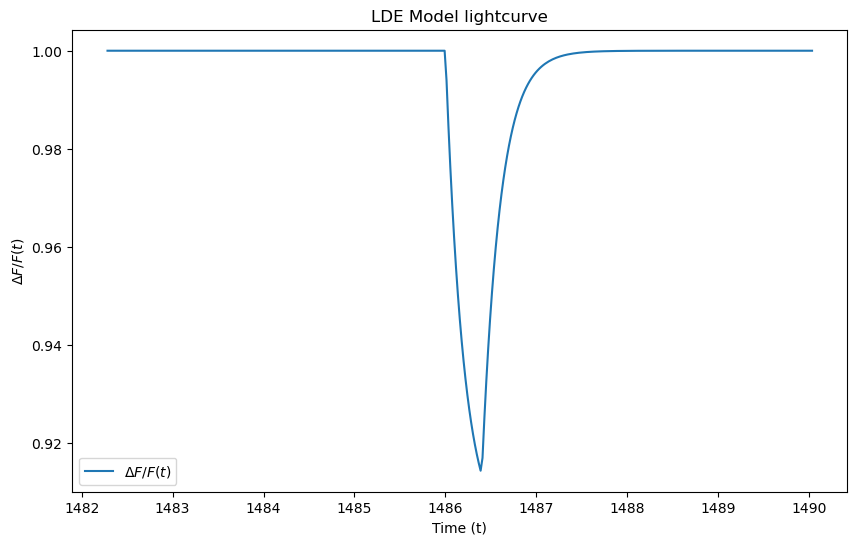

In [79]:
def ldecomet(t, K, beta, t0, delta_t):
    # Calculate Δ
    delta = np.where(t >= t0, beta * (t - t0), 0)
    
    # Calculate Δ'
    delta_prime = np.where(t >= t0 + delta_t, beta * (t - t0 - delta_t), 0)
    
    # Calculate the relative flux decrease
    delta_f_over_f = K * (np.exp(-delta) - np.exp(-delta_prime))
    
    return delta_f_over_f

# Define parameters
K = 0.1         # Example value for K
beta = 5      # Example value for β
t0 = 1486        # Example value for t0
delta_t = 0.4  # Example value for Δt

# Generate time values
t = lc.time.value[600:1000]

# Calculate relative flux decrease
flux_decrease = ldecomet(t, K, beta, t0, delta_t)

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(t, 1 - abs(flux_decrease), label=r'$\Delta F / F (t)$')
plt.xlabel('Time (t)')
plt.ylabel(r'$\Delta F / F (t)$')
plt.title('LDE Model lightcurve')
plt.legend()
plt.show()

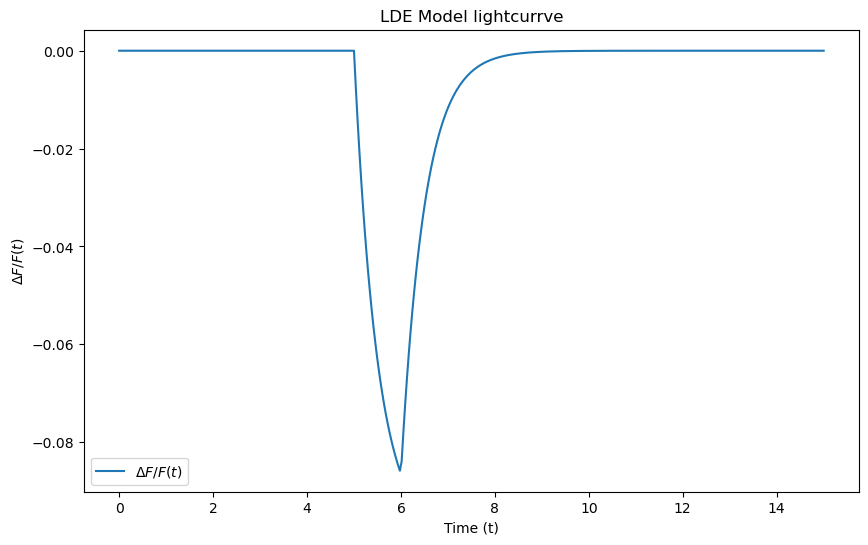

In [80]:
# Generate time values
t = np.linspace(0, 15, 400)

# Define parameters
K = 0.1         # Example value for K
beta = 2      # Example value for β
t0 = 5        # Example value for t0
delta_t = 1  # Example value for Δt


# Calculate relative flux decrease
flux_decrease = relative_flux_decrease(t, K, beta, t0, delta_t)

# Plot the function
plt.figure(figsize=(10, 6))
plt.plot(t, flux_decrease, label=r'$\Delta F / F (t)$')
plt.xlabel('Time (t)')
plt.ylabel(r'$\Delta F / F (t)$')
plt.title('LDE Model lightcurrve')
plt.legend()
plt.show()